# Google OR-Tools で la40 を解く

## 参考

- qiita 記事: https://qiita.com/rm0063vpedc15/items/473fc3a1c8c5de97a213
- Google OR-Tools 公式 (`cp_model` について) : https://developers.google.com/optimization/reference/python/sat/python/cp_model#cp_model.CpModel

In [1]:
"""Minimal jobshop example."""
import collections
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt


# データ読み込み

In [2]:
# la40
with open('data/jssp/la40.txt', 'r') as f:
    la40_data: list = [
        line.rstrip("\n").split("\t")
        for line in f.readlines()
    ]


num_machines, num_jobs = la40_data[0]
processing_time_per_job = la40_data[1:16]
machine_sequence_per_job = la40_data[16:31]


# Job情報整形
# 1つのジョブの全タスクの実行マシンIDと実行時間をまとめたもの
JobData = list[tuple[int, int]]
# tuple[int, int]: (machine_id, processing_time)

# ※ Job情報の見本
# jobs_data = [  # task = (machine_id, processing_time).
#     [(0, 3), (1, 2), (2, 2)],  # Job0
#     [(0, 2), (2, 1), (1, 4)],  # Job1
#     [(1, 4), (2, 3)],  # Job2
#     [(1, 2), (0, 1), (2, 4)],  # Job3
#     [(2, 1), (0, 2), (1, 1)],  # Job4
# ]

# la40 から取得したデータを上記の形式に変換する
jobs_data: list[JobData] = []
for process_times_for_job, machine_seqs_for_job in zip(processing_time_per_job, machine_sequence_per_job):
    job_data: JobData = [
        (int(machine_seq), int(process_time))
        for process_time, machine_seq in zip(process_times_for_job, machine_seqs_for_job)
    ]
    jobs_data.append(job_data)

# jobs_data

# ソルバーの初期化、決定変数・制約条件・目的関数の定義

In [3]:
# Machineの数
machines_count = 1 + max(task[0] for job in jobs_data for task in job)
all_machines = range(machines_count)

# 全 Job 内の全 Task の合計時間
horizon = sum(
    task[1]
    for job in jobs_data
    for task in job
)

# モデルの作成
model = cp_model.CpModel()

In [4]:
# Taskの種類
task_type = collections.namedtuple('task_type', 'start end interval')

# ジョブタスクの処理時間
all_tasks = {}
machine_to_intervals = collections.defaultdict(list)

# 開始、終了、処理時間変数を作成
for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine = task[0]  # タスクを実行できるマシンの ID
        duration = task[1]  # タスク実行の所要時間
        suffix = '_%i_%i' % (job_id, task_id)
        start_var = model.NewIntVar(0, horizon, 'start' + suffix)  # NewIntVar(最小値, 最大値, 変数名)
        end_var = model.NewIntVar(0, horizon, 'end' + suffix)
        interval_var = model.NewIntervalVar(
            start_var, duration, end_var, 'interval' + suffix
        )
        all_tasks[job_id, task_id] = task_type(
            start=start_var, end=end_var, interval=interval_var
        )
        machine_to_intervals[machine].append(interval_var)


In [5]:
# -------------------------------------------------------
# Constraint
# -------------------------------------------------------
# 重複無の制約を追加
for machine in all_machines:
    # 各マシンにおいて行われるジョブの実行時間帯が重なってはならない
    model.AddNoOverlap(machine_to_intervals[machine])

# 実行順序の制約を追加
for job_id, job in enumerate(jobs_data):
    for task_id in range(len(job) - 1):
        # 各ジョブにおける1つ1つのタスクの順番が守られていなければならない
        model.Add(all_tasks[job_id, task_id + 1].start >= all_tasks[job_id, task_id].end)

# -------------------------------------------------------
# 目的関数
# -------------------------------------------------------
obj_var = model.NewIntVar(0, horizon, 'makespan')

# makespan: 全てのジョブの全てのタスクの終了時間の内、一番遅いもの
model.AddMaxEquality(obj_var, [
    all_tasks[job_id, len(job) - 1].end
    for job_id, job in enumerate(jobs_data)
])

# 最適化で、makespanをMinimize(最小に)することを目指す
model.Minimize(obj_var)


# ソルバーの実行

In [6]:
solver = cp_model.CpSolver()
status = solver.Solve(model)


# Statistics.
print("\nStatistics")
print(f"  - conflicts: {solver.NumConflicts()}")
print(f"  - branches : {solver.NumBranches()}")
print(f"  - wall time: {solver.WallTime()}s")


if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print(f'Optimal Schedule Length: {solver.ObjectiveValue()}')
else:
    print('No solution found.')



Statistics
  - conflicts: 24005
  - branches : 27348
  - wall time: 21.909737786s
Optimal Schedule Length: 1222.0


# 実行結果の整理

In [7]:
# 解取り回し用
assigned_task_type = collections.namedtuple(
    'assigned_task_type', 'start job machine_id task_id duration'
)

# Job毎に割当てられたTaskのリストを作成
assigned_jobs = collections.defaultdict(list)  # 見つかった解を格納する
for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine_id = task[0]
        start = solver.Value(all_tasks[job_id, task_id].start)
        assigned_job = assigned_task_type(
            start=start,
            job=job_id,
            machine_id=machine_id,
            task_id=task_id,
            duration=task[1]
        )
        assigned_jobs[job_id].append(assigned_job)
    assigned_jobs[job_id] = sorted(assigned_jobs[job_id])

# assigned_jobs

# 結果の可視化

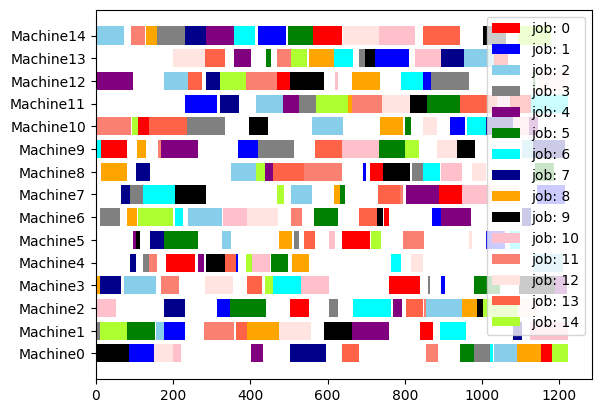

In [8]:
fig, ax = plt.subplots()

jobTaskIds: list[int] = list(range(0, 15))
machineIds: list[int] = list(range(0, 15))

# 縦軸の値
machine_name = [
    f"Machine{k}"
    for k in machineIds
]

# 横軸の値
start_time = [0] * len(jobTaskIds)
process_time = [0] * len(jobTaskIds)

# 15色のカラー
colors = [
    "red", "blue", "skyblue", "gray", "purple",
    "green", "cyan", "darkblue", "orange", "black",
    "pink", "salmon", "mistyrose", "tomato", "greenyellow"
]


for jobId, assigned_tasks in assigned_jobs.items():
    color = colors[jobId]
    for task in assigned_tasks:
        start_time[task.machine_id - 1] = task.start
        process_time[task.machine_id - 1] = task.duration

        # 1回だけ legend 登録用の label を渡す
        if task.task_id == 0:
            ax.barh(machine_name, process_time, left = start_time, color=color, label=f"job: {jobId}")
        else:
            ax.barh(machine_name, process_time, left = start_time, color=color)
        start_time[task.machine_id - 1] = 0
        process_time[task.machine_id - 1] = 0

plt.legend()
